# Using Neural Networks to approximate Q Functions

<img src="imagenes/cnn.png" width="400px"/>



In [1]:
import numpy as np
from utils.plot_utils import PlotQApprox2D
from agents.deepQ import CustomCNNasQ
from agents.agentsNN import ExperienceDataset
from utils.interpreters import GridW_CNN_interpreter
import torch
from torch.distributions import MultivariateNormal
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns

Creamos una Red Neuronal Convolucional (CNN) para aproximar el valor de una pareja estado, acción mediante un objeto `CustomCNNasQ` del módulo `agents.deepQ`, el cual instanciaremos con el nombre de `value_approximator`:

In [2]:
CNN_parameters = {'nA':4,
                  'alpha':1e-3,
                  'optimizer_class':'Adam'}
value_approximator = CustomCNNasQ(parameters=CNN_parameters)
value_approximator.summary()

+----------+------------+
| Modules  | Parameters |
+----------+------------+
| 0.weight |     16     |
|  0.bias  |     4      |
| 3.weight |    128     |
|  3.bias  |     8      |
| 6.weight |    2048    |
|  6.bias  |     64     |
| 8.weight |    256     |
|  8.bias  |     4      |
+----------+------------+
Total Trainable Params: 2528


Observe que `value_approximator` tiene un método `predict()`, el cual devuelve el valor predecido de una pareja estado, acción. Como recién inicializamos el objeto, el valor predecido es aleatorio:

In [3]:
state = torch.tensor([[[0, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 0, 0],
                      [0, 0, 0, 0],
                      ]], dtype=torch.float32)
action = 2
state_action_value = value_approximator.predict(state=state,
                                                action=action)
print(f'Predicted value for action {action}: {state_action_value}')
q_values = value_approximator.values_vector(state)
print(f'All q_values:', q_values)

Predicted value for action 2: -0.32094472646713257
All q_values: [0.18884743750095367, -0.28938084840774536, -0.32094472646713257, 0.4146767854690552]


Observe que predecimos $q(s, a)$ para cada estado $s$. La acción que el agente debe tomar (módulo $\epsilon$) es la que tenga mayor valor $q$. Los mejores valores y su correspondiente acción los podemos dibujar de la siguiente manera:

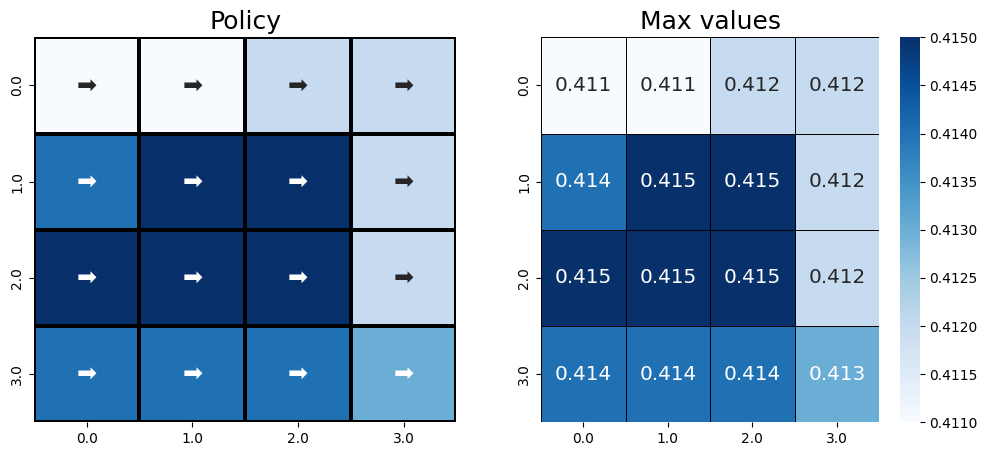

In [4]:
dict_acciones = {0:"⬆", 1:"⬅", 2:"⬇", 3:"➡"}
# get scales
state_scales = [[0, 3], [0, 3]]
x_position_scale = state_scales[0]
x_velocity_scale = state_scales[1]
q_plot = PlotQApprox2D(Q=value_approximator,
                       state_scales=state_scales, 
                       dict_acciones=dict_acciones,
                       mesh_size=4,
                       state_interpreter=GridW_CNN_interpreter)
q_plot.best_actions_with_values(max_deci=3)

Podemos decirle a la función que aprenda que la acción 2 tiene el valor de una distribución normal bivariada centrada en $(0,0)$. En la siguiente celda vemos una visualización de esta función:

<Axes: >

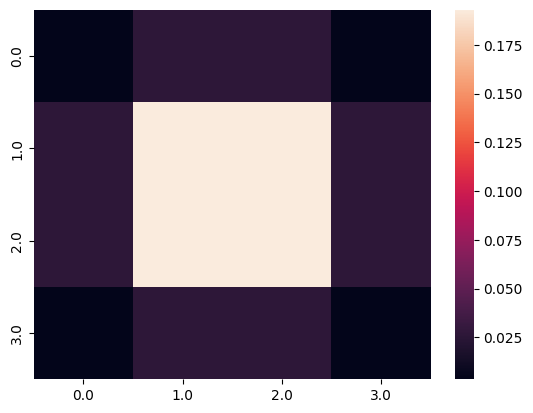

In [5]:
# Create mesh from bidimensional states
mesh_size = 4
x_lims = state_scales[0]
X = np.linspace(x_lims[0], x_lims[1], mesh_size)
y_lims = state_scales[1]
Y = np.linspace(y_lims[0], y_lims[1], mesh_size)
# Create labels
xticklabels = [str(round(x, 1)) for x in X]
yticklabels = [str(round(y, 1)) for y in Y]
# Create q table from Q function
actions = list(dict_acciones.keys())
n = len(actions)
m = MultivariateNormal(torch.tensor([1.5,1.5]), torch.tensor([[0.5, 0], [0, 0.5]]))
v_table = np.zeros((mesh_size, mesh_size, n))
for j in range(mesh_size):
    for i in range(mesh_size):
        state = (X[j], Y[i])
        state = torch.tensor(state, dtype=torch.float32)
        for a in range(n):
            v_table[(mesh_size - 1) - i, j, a] = np.exp(m.log_prob(state).item())
V = np.max(v_table, axis=2)
sns.heatmap(V,
            xticklabels=xticklabels,
            yticklabels=yticklabels)

En la siguiente celda creamos unos pocos datos de prueba, los empacamos en un `DataLoader` (de Pytorch) y los visualizamos para darnos una idea de los datos sobre los cuales entrenaremos a la red: 

In [6]:
def re_scale(x_position, x_velocity):
    X_bins = np.linspace(x_lims[0], x_lims[1], mesh_size + 1)
    Y_bins = np.linspace(y_lims[0], y_lims[1], mesh_size + 1)
    X_index = X_bins.searchsorted(x_position) - 1
    Y_index = Y_bins.searchsorted(x_velocity) - 1
    return (X_index, Y_index)
    
def simulate_data(sample_size):
    m = MultivariateNormal(torch.tensor([1.5,1.5]), torch.tensor([[0.5, 0], [0, 0.5]]))
    # Create bookkeeping lists
    states = list()
    actions = list()
    updates = list()
    # Simulate total rewards
    for i in range(sample_size):
        x_position = np.random.uniform(low=x_position_scale[0], high=x_position_scale[1])
        x_velocity = np.random.uniform(low=x_velocity_scale[0], high=x_velocity_scale[1])
        state = (x_position, x_velocity)
        state = re_scale(x_position, x_velocity)
        state_ = torch.tensor((X[state[0]], Y[state[1]]), dtype=torch.float32)
        state = GridW_CNN_interpreter(state)
        states.append(state)
        actions.append(2)
        logprob = m.log_prob(state_).item()
        total_reward = np.exp(logprob)
        updates.append(total_reward)
    return states, actions, updates

sample_size = 4
batch_size = 2
states, actions, updates = simulate_data(sample_size=sample_size)
ds = ExperienceDataset(states, actions, updates)
ds_loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
counter = 0
for batch_states, batch_actions, batch_updates in ds_loader:
    counter += 1
    print('-'*10 + f'Batch number {counter}' + '-'*10)
    print(f'states:\n\t{batch_states}')
    print(f'actions:\n\t{batch_actions}')
    print(f'updates:\n\t{batch_updates}')
    print('\n')

----------Batch number 1----------
states:
	tensor([[[[0., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]],


        [[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 1.]]]])
actions:
	tensor([2, 2])
updates:
	tensor([0.1931, 0.0035])


----------Batch number 2----------
states:
	tensor([[[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 0.]]],


        [[[0., 1., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]]])
actions:
	tensor([2, 2])
updates:
	tensor([0.1931, 0.0261])




Ahora que tenemos una idea de los datos, creamos un dataset más numeroso y realizamos el entrenamiento: 

In [7]:
sample_size = 256
batch_size = 2
states, actions, updates = simulate_data(sample_size=sample_size)
ds = ExperienceDataset(states, actions, updates)
ds_loader = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [8]:
num_epochs = 100
value_approximator.reset()
for e in tqdm(range(num_epochs)):
    value_approximator.learn(ds_loader)

  0%|          | 0/100 [00:00<?, ?it/s]

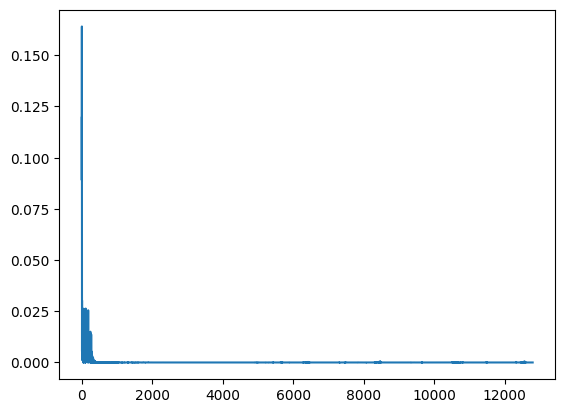

In [9]:
plt.plot(value_approximator.losses)

Visualizamos la política aprendida con base en los mejores valores de acción:

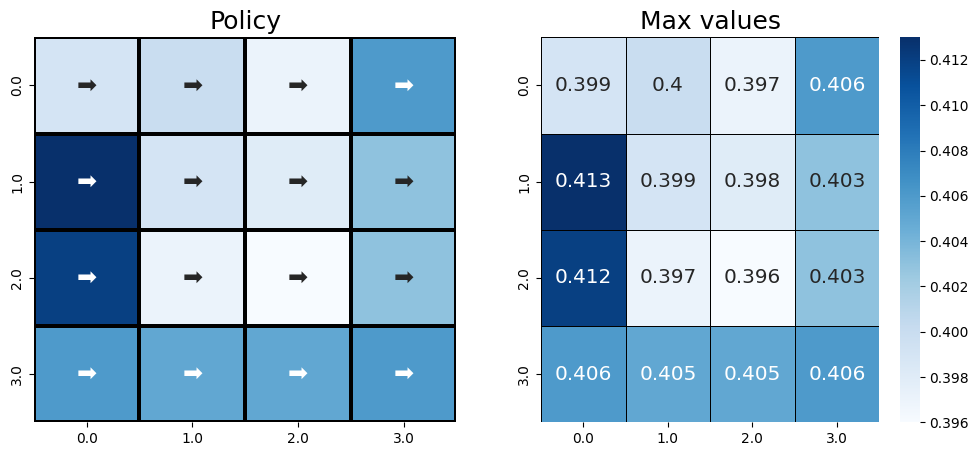

In [10]:
dict_acciones = {0:"⬆", 1:"⬅", 2:"⬇", 3:"➡"}
state_scales = [[0, 3], [0, 3]]
q_plot = PlotQApprox2D(Q=value_approximator,
                       state_scales=state_scales, 
                       dict_acciones=dict_acciones,
                       mesh_size=4,
                       state_interpreter=GridW_CNN_interpreter)
q_plot.best_actions_with_values(max_deci=3)

In [11]:
state = torch.tensor([[[1, 0, 0, 0],
                      [0, 0, 0, 0],
                      [0, 0, 0, 0],
                      [0, 0, 0, 0],
                      ]], dtype=torch.float32)
action = 2
state_action_value = value_approximator.predict(state=state,
                                                action=action)
print(f'Predicted value for action {action}: {state_action_value}')
q_values = value_approximator.values_vector(state)
print(f'All q_values:', q_values)

Predicted value for action 2: 0.004160143435001373
All q_values: [0.17194145917892456, -0.27023810148239136, 0.004160143435001373, 0.399084210395813]
